In [1]:
%load_ext sql
%sql sqlite:///base.db
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

# Ограничение целостности БД

**Стандарт языка SQL** поддерживает только декларативные ограничения целостности, реализуемые в виде:

- ограничения домена;

- ограничения, входящие в определение таблицы;

- ограничения, хранящиеся в базе данных в виде независимых утверждений (check)

**Ограничения стандарта SQL:**

- PRIMARY KEY
- FOREIGN KEY (ON DELETE, ON UPDATE)
- NOT NULL
- UNIQUE
- DEFAULT
- CHECK

In [2]:
%%sql
PRAGMA foreign_keys=on;

DROP TABLE IF EXISTS Orders;
DROP TABLE IF EXISTS Customers;

CREATE TABLE Customers (
          customer_id integer PRIMARY KEY,
          cust_name varchar(30),
          registered datetime,
          address varchar(50)
          );

CREATE TABLE Orders (
          order_ID integer PRIMARY KEY,
          customer_id integer NOT NULL,
          order_sum integer NOT NULL,
          order_date datetime NOT NULL,
          address varchar(50),
          FOREIGN KEY (customer_id) REFERENCES Customers(customer_id)
             ON UPDATE CASCADE
             ON DELETE SET DEFAULT
           --  ON UPDATE RESTRICT
           --  ON DELETE CASCADE

          -- RESTRICT, CASCADE, SET NULL, SET DEFAULT, NO ACTION
          CHECK (order_sum > 0)
          );

 * sqlite:///base.db
Done.
Done.
Done.
Done.
Done.


[]

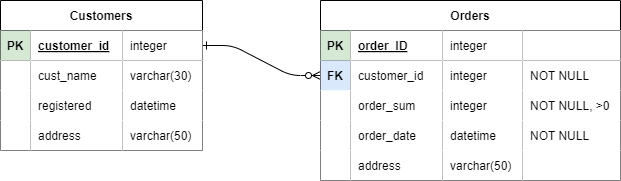

In [3]:
%%sql
INSERT INTO Customers(cust_name) VALUES("Антон");
INSERT INTO Customers(cust_name, address) VALUES("Павел", "Адрес1");
INSERT INTO Customers(cust_name) VALUES("Наталья");

 * sqlite:///base.db
1 rows affected.
1 rows affected.
1 rows affected.


[]

In [4]:
%sql SELECT * FROM Customers;

 * sqlite:///base.db
Done.


customer_id,cust_name,registered,address
1,Антон,None,None
2,Павел,None,Адрес1
3,Наталья,None,None


In [5]:
%%sql
INSERT INTO Orders(customer_id, order_sum, order_date) VALUES(1, 24000, '2025-03-01');
INSERT INTO Orders(customer_id, order_sum, order_date) VALUES(2, 36000, '2025-03-01');
INSERT INTO Orders(customer_id, order_sum, order_date) VALUES(3, 14000, '2025-03-01');
INSERT INTO Orders(customer_id, order_sum, order_date) VALUES(2, 22000, '2025-03-02');

 * sqlite:///base.db
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


[]

In [6]:
%sql SELECT * FROM Orders;

 * sqlite:///base.db
Done.


order_ID,customer_id,order_sum,order_date,address
1,1,24000,2025-03-01,None
2,2,36000,2025-03-01,None
3,3,14000,2025-03-01,None
4,2,22000,2025-03-02,None


In [8]:
%%sql
UPDATE Customers set customer_id = 4 WHERE cust_name = 'Антон';

 * sqlite:///base.db
1 rows affected.


[]

In [9]:
%sql SELECT * FROM Orders;

 * sqlite:///base.db
Done.


order_ID,customer_id,order_sum,order_date,address
1,4,24000,2025-03-01,None
2,2,36000,2025-03-01,None
3,3,14000,2025-03-01,None
4,2,22000,2025-03-02,None


In [10]:
%%sql
INSERT INTO Orders(customer_id, order_sum, order_date) VALUES(1, -24000, '2025-02-21');

 * sqlite:///base.db
(sqlite3.IntegrityError) CHECK constraint failed: order_sum > 0
[SQL: INSERT INTO Orders(customer_id, order_sum, order_date) VALUES(1, -24000, '2025-02-21');]
(Background on this error at: https://sqlalche.me/e/20/gkpj)


In [11]:
%%sql
DELETE from Customers where customer_id = 3;

 * sqlite:///base.db
(sqlite3.IntegrityError) NOT NULL constraint failed: Orders.customer_id
[SQL: DELETE from Customers where customer_id = 3;]
(Background on this error at: https://sqlalche.me/e/20/gkpj)


In [12]:
%sql SELECT * FROM Orders;

 * sqlite:///base.db
Done.


order_ID,customer_id,order_sum,order_date,address
1,4,24000,2025-03-01,None
2,2,36000,2025-03-01,None
3,3,14000,2025-03-01,None
4,2,22000,2025-03-02,None


# Несогласованность

In [13]:
%%sql
Pragma foreign_keys=on;

DROP TABLE if exists Orders;
DROP TABLE if exists Customers;

CREATE TABLE Customers(
          customer_id integer PRIMARY KEY,
          cust_name varchar(30) NOT NULL UNIQUE,
          registered datetime NOT NULL,
          address varchar(50)
          );

CREATE TABLE Orders(
          order_ID integer PRIMARY KEY,
          customer_id integer NOT NULL,
          order_sum integer NOT NULL,
          order_date datetime NOT NULL,
          address varchar(50),
          FOREIGN KEY (customer_id) REFERENCES Customers(customer_id)
          );

 * sqlite:///base.db
Done.
Done.
Done.
Done.
Done.


[]

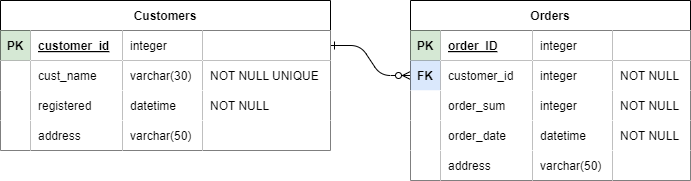

In [16]:
%%sql
INSERT INTO Orders(customer_id, order_sum, order_date) VALUES(1, 24000, '2025-03-01');

 * sqlite:///base.db
(sqlite3.IntegrityError) FOREIGN KEY constraint failed
[SQL: INSERT INTO Orders(customer_id, order_sum, order_date) VALUES(2, 24000, '2025-03-01');]
(Background on this error at: https://sqlalche.me/e/20/gkpj)


In [14]:
%%sql
INSERT INTO Customers(cust_name, registered, address) VALUES("Антон", '2025-03-03', "адрес Антона");
INSERT INTO Orders(customer_id, order_sum, order_date) VALUES(1, 24000, '2025-03-01');

 * sqlite:///base.db
1 rows affected.
1 rows affected.


[]

In [15]:
%%sql
-- Ничего не мешает делать заказы до регистрации -> несогласованность
SELECT order_ID, cust_name, registered, order_date FROM
Customers JOIN Orders USING(customer_id);

 * sqlite:///base.db
Done.


order_ID,cust_name,registered,order_date
1,Антон,2025-03-03,2025-03-01


# Ограничения не из стандарта SQL:

Триггер — это хранимая процедура, которая не вызывается непосредственно, а исполняется при наступлении определенного события (UPDATE, INSERT, DELETE).

Триггеры можно разделить на три вида по их применению:

BEFORE

AFTER

<s>INSTEAD OF</s> (для VIEW)


---


И на 3 вида по типу команд:

DELETE

UPDATE

INSERT

https://www.sqlite.org/lang_createtrigger.html

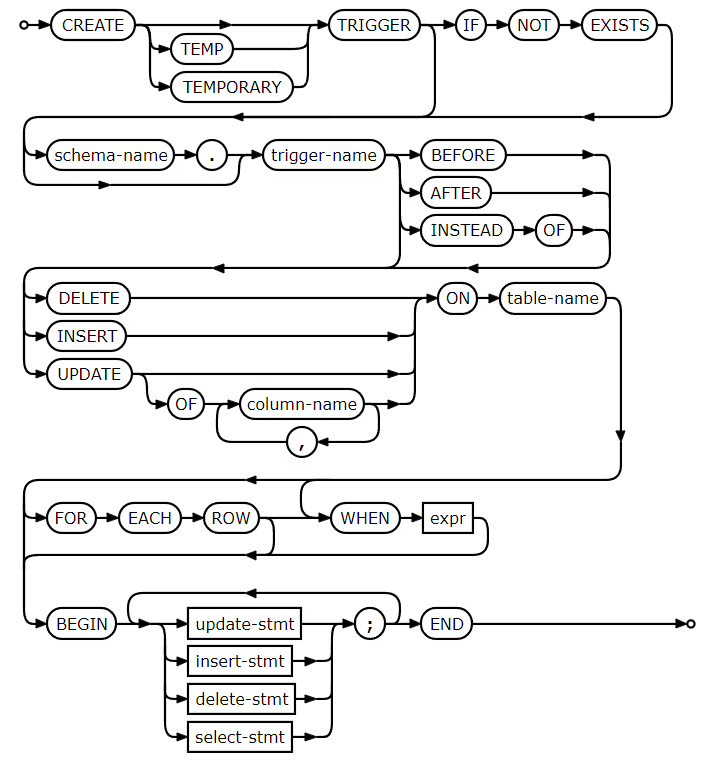

Замечания:
Триггер может создаваться для какой-либо конкретной таблицы или для строк (FOR EACH ROW)
В SQLite нет табличных триггеров, а только FOR EACH ROW триггеры, которые срабатывают при изменении каждой строки в таблице.

In [17]:
%%sql
SELECT * FROM Customers;

 * sqlite:///base.db
Done.


customer_id,cust_name,registered,address
1,Антон,2025-03-03,адрес Антона


NEW - новое значение в таблице

OLD - старое значение в таблице (до модификации)

Пример 1 - После введения нового адреса заказа обновить адрес клиента:

In [18]:
%%sql

DROP TRIGGER if exists upd_address;

CREATE TRIGGER upd_address AFTER INSERT ON Orders
BEGIN
UPDATE Customers SET address = new.address WHERE customer_id = new.customer_id;
END;

 * sqlite:///base.db
Done.
Done.


[]

In [19]:
%%sql
INSERT INTO Orders(customer_id, order_sum, order_date, address)
    VALUES(1, 7000, '2025-03-03', "Новый адрес Антона");

 * sqlite:///base.db
1 rows affected.


[]

In [25]:
%%sql
SELECT * FROM Orders;

 * sqlite:///base.db
Done.


order_ID,customer_id,order_sum,order_date,address
1,1,24000,2025-03-01,None
2,1,7000,2025-03-03,Новый адрес Антона


In [24]:
%%sql
SELECT * FROM Customers;

 * sqlite:///base.db
Done.


customer_id,cust_name,registered,address
1,Антон,2025-03-03,Новый адрес Антона


In [23]:
%%sql
INSERT INTO Orders(customer_id, order_sum, order_date)
    VALUES(1, 4000, '2025-03-03');

 * sqlite:///base.db
(sqlite3.IntegrityError) NOT NULL constraint failed: Customers.address
[SQL: INSERT INTO Orders(customer_id, order_sum, order_date)
    VALUES(1, 4000, '2025-03-03');]
(Background on this error at: https://sqlalche.me/e/20/gkpj)


In [52]:
%%sql
SELECT * FROM Customers; -- упс

 * sqlite:///base.db
Done.


customer_id,cust_name,registered,address,cust_info
1,Антон,2025-03-03,Новый адрес Антона,None


Исправляем:

In [45]:
%%sql

DROP TRIGGER upd_address;

CREATE TRIGGER upd_address AFTER INSERT ON Orders
WHEN new.address IS NOT NULL
BEGIN
UPDATE Customers SET address = new.address WHERE customer_id = new.customer_id;
END;

 * sqlite:///base.db
Done.
Done.


[]

## RAISE()

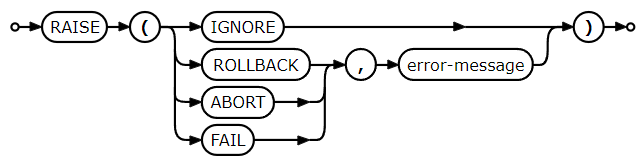

Пример 2 - решение несогласованности

In [26]:
%%sql

DROP TRIGGER if exists reg_check;

CREATE TRIGGER reg_check BEFORE INSERT
ON Orders
BEGIN
SELECT RAISE (FAIL, "Дата заказа раньше регистрации клиента")
    FROM Customers JOIN Orders USING(customer_id)
        WHERE new.order_date < registered;
END;

 * sqlite:///base.db
Done.
Done.


[]

In [27]:
%%sql
INSERT INTO Orders(customer_id, order_sum, order_date, address)
    VALUES(1, 1000, '2025-03-01', "Новый адрес Антона");

 * sqlite:///base.db
(sqlite3.IntegrityError) Дата заказа раньше регистрации клиента
[SQL: INSERT INTO Orders(customer_id, order_sum, order_date, address)
    VALUES(1, 1000, '2025-03-01', "Новый адрес Антона");]
(Background on this error at: https://sqlalche.me/e/20/gkpj)


In [28]:
%%sql
SELECT * FROM Customers;

 * sqlite:///base.db
Done.


customer_id,cust_name,registered,address
1,Антон,2025-03-03,Новый адрес Антона


In [29]:
%%sql
INSERT INTO Orders(customer_id, order_sum, order_date)
    VALUES(1, 4000, '2025-03-03');

 * sqlite:///base.db
(sqlite3.IntegrityError) NOT NULL constraint failed: Customers.address
[SQL: INSERT INTO Orders(customer_id, order_sum, order_date)
    VALUES(1, 4000, '2025-03-03');]
(Background on this error at: https://sqlalche.me/e/20/gkpj)


In [30]:
%%sql
SELECT * FROM Orders;

 * sqlite:///base.db
Done.


order_ID,customer_id,order_sum,order_date,address
1,1,24000,2025-03-01,None
2,1,7000,2025-03-03,Новый адрес Антона


In [31]:
%%sql
UPDATE Orders set order_date = '2025-01-01' WHERE customer_id = 1;

 * sqlite:///base.db
2 rows affected.


[]

In [32]:
%%sql
SELECT * FROM Orders;

 * sqlite:///base.db
Done.


order_ID,customer_id,order_sum,order_date,address
1,1,24000,2025-01-01,None
2,1,7000,2025-01-01,Новый адрес Антона


In [33]:
%%sql
SELECT * FROM Customers;

 * sqlite:///base.db
Done.


customer_id,cust_name,registered,address
1,Антон,2025-03-03,Новый адрес Антона


In [34]:
%%sql

DROP TRIGGER if exists reg_check_update;

CREATE TRIGGER reg_check_update BEFORE UPDATE OF order_date
ON Orders
BEGIN
SELECT RAISE (FAIL, "Дата заказа раньше регистрации клиента")
    FROM Customers JOIN Orders USING(customer_id)
        WHERE new.order_date < registered;
END;

 * sqlite:///base.db
Done.
Done.


[]

## Пример 3 - "Архив"

Если удалили заказ, он сохраняется в "архиве"

In [35]:
%%sql

DROP TABLE if exists log_orders;

CREATE TABLE log_orders (
          order_ID integer PRIMARY KEY,
          customer_id integer NOT NULL,
          order_sum integer,
          order_date datetime NOT NULL,
          address NOT NULL
          );

 * sqlite:///base.db
Done.
Done.


[]

In [36]:
%%sql

DROP TRIGGER if exists log;

CREATE TRIGGER log BEFORE DELETE
ON Orders
BEGIN
INSERT INTO log_orders(order_ID, customer_id, order_sum, order_date, address)
    VALUES (OLD.order_ID, OLD.customer_id, OLD.order_sum, OLD.order_date, OLD.address);
END;

 * sqlite:///base.db
Done.
Done.


[]

In [40]:
%%sql
SELECT * FROM Orders;

 * sqlite:///base.db
Done.


order_ID,customer_id,order_sum,order_date,address
1,1,24000,2025-01-01,None


In [41]:
%%sql
SELECT * FROM log_orders;

 * sqlite:///base.db
Done.


order_ID,customer_id,order_sum,order_date,address
2,1,7000,2025-01-01,Новый адрес Антона


In [43]:
%%sql
DELETE FROM Orders WHERE order_ID = 2;

 * sqlite:///base.db
(sqlite3.OperationalError) no such table: Orders
[SQL: DELETE FROM Orders WHERE order_ID = 2;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [42]:
%%sql
DROP TABLE Orders;

 * sqlite:///base.db
Done.


[]